# https://www.kaggle.com/c/mercari-price-suggestion-challenge 
# https://www.kaggle.com/c/home-credit-default-risk

Выбрать одно из двух соревнований. Выбирайте по данным, с которыми вам интереснее работать.

In [1]:
from __future__ import print_function
import time
import re
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, PolynomialFeatures

from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler

# Ансамбли

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

%matplotlib inline
plt.rcParams["figure.figsize"] = (6, 4)
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_columns = None

Using TensorFlow backend.
/Users/mary/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Задание
1. Сделать baseline submission
  * Исследовать признак price (TARGET). 
  * Исследовать признак price (TARGET) в зависимости от brand_name или других признаков
2. Реализовать цикл анализа
  * признаки -> модель -> настройка параметров -> лучшая модель и ее значение метрики качества на кросс-валидации
3. Провести простые преобразования признаков и добавление простых признаков
  * разделить category_name на уровни
  * посмотреть на наличие числовых значений в описании и имени
  * ...
4. Составить план по применению нескольких моделей на разных признаках
  * спроектируйте эксперимент. Нужно заранее спланировать порядок перебора признаков и моделей. Потом только писать код. Обратный порядок вызывает необходимость переписывать существующий код, это трата времени
5. Просмотреть 1-5 kernel на kaggle. (только в таком порядке. сначала работаем самостоятельно, потом смотрим идеи других. при появлении опыта можно сразу начинать с них)
6. Скорректировать план
  * убрать пункты, которые кажутся неудачными
  * добавить идеи из kernel, кажущиеся удачными
7. Построить модель, выбрать лучшую
8. Построить ансамбль, настрить парамертры. Сравнить с другими моделями.
9. Применить и засабмитить лучшую на cv модель
10. Прислать блокнот и свой ник в лидерборде

# Будем использовать датасет из соревнования Home Credit Default Risk

### Используйте параметр nrows, чтобы уменьшить выборку и сделать базовый разведочный анализ данных

In [2]:
df_train = pd.read_csv('home-credit-default-risk/application_train.csv')
df_test = pd.read_csv('home-credit-default-risk/application_test.csv')

In [3]:
print(df_train.info())
print()
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None


In [4]:
df = pd.read_csv('home-credit-default-risk/application_train.csv', nrows=10000)

In [5]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00,406597.50,24700.50,351000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-9461,-637,-3648.00,-2120,nan,1,1,0,1,1,0,Laborers,1.00,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,reg oper account,block of flats,0.01,"Stone, brick",No,2.00,2.00,2.00,2.00,-1134.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0,Cash loans,F,N,N,0,270000.00,1293502.50,35698.50,1129500.00,Family,State servant,Higher education,Married,House / apartment,0.00,-16765,-1188,-1186.00,-291,nan,1,1,0,1,1,0,Core staff,2.00,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,nan,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.05,0.00,0.01,0.09,0.05,0.99,0.80,0.05,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.00,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.01,reg oper account,block of flats,0.07,Block,No,1.00,0.00,1.00,0.00,-828.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,0,Revolving loans,M,Y,Y,0,67500.00,135000.00,6750.00,135000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01,-19046,-225,-4260.00,-2531,26.00,1,1,1,1,1,0,Laborers,1.00,2,2,MONDAY,9,0,0,0,0,0,0,Government,nan,0.56,0.73,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0.00,0.00,0.00,0.00,-815.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.0

## 1. EDA + Baseline

Посмотрим, насколько сбалансированны классы в выборке

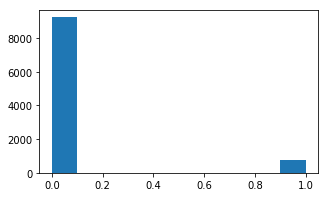

In [6]:
plt.figure(figsize=(5,3))
plt.hist(df.TARGET);

In [7]:
vals, counts = np.unique(df.TARGET, return_counts=True)
dict(zip(vals, counts))

{0: 9225, 1: 775}

Объектов с TARGET == 1 очень мало: <10%, выборка неоднородна.

Теперь выведем информацию по отсутствующим значениям:

In [8]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
df_both=pd.concat([df_train.drop(columns=['TARGET', 'SK_ID_CURR']), df_train.drop(columns=['SK_ID_CURR'])], 
                  axis=0)
missing_values = missing_values_table(df_both).reset_index()
missing_values

/Users/mary/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Selected dataframe has 121 columns.
There are 68 columns that have missing values.


,index,Missing Values,% of Total Values
0,COMMONAREA_AVG,429730,69.90
1,COMMONAREA_MODE,429730,69.90
2,COMMONAREA_MEDI,429730,69.90
3,NONLIVINGAPARTMENTS_MODE,427028,69.40
4,NONLIVINGAPARTMENTS_MEDI,427028,69.40
5,NONLIVINGAPARTMENTS_AVG,427028,69.40
6,FONDKAPREMONT_MODE,420590,68.40
7,LIVINGAPARTMENTS_MODE,420398,68.40
8,LIVINGAPARTMENTS_MEDI,420398,68.40
9,LIVINGAPARTMENTS_AVG,420398,68.40


Поскольку есть признаки с весьма большим количеством пропущенных наблюдений, имеет смысл во время препроцессинга разделить такие признаки по наличию значения (есть/нет). 

Посмотрим, сколько категорий присутствует в категориальных признаках и сколько вообще таких признаков:

In [9]:
print(df.dtypes.value_counts())
cats=pd.Series(df_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0), name='num_categories'
         ).reset_index()
cats

float64    65
int64      41
object     16
dtype: int64


,index,num_categories
0,NAME_CONTRACT_TYPE,2
1,CODE_GENDER,3
2,FLAG_OWN_CAR,2
3,FLAG_OWN_REALTY,2
4,NAME_TYPE_SUITE,7
5,NAME_INCOME_TYPE,8
6,NAME_EDUCATION_TYPE,5
7,NAME_FAMILY_STATUS,6
8,NAME_HOUSING_TYPE,6
9,OCCUPATION_TYPE,18


В качестве бейзлайн модели, возьмем сразу градиентный бустинг (LGBM), но без настройки параметров (предобработку осуществим примитивным способом)

In [18]:
# simple preprocess
base_x, base_y = df_train.dropna().drop(columns=['TARGET', 'SK_ID_CURR']), df_train.dropna().TARGET
base_test = df_test.drop(columns=['SK_ID_CURR'])

noncategorical = base_x.columns[base_x.columns.isin(list(cats['index']))]

for col in base_x.columns:
    if base_x[col].dtype == 'object':
        base_x.loc[base_x[col].isna(), col] = 'nan'
        base_x[col] = LabelEncoder().fit_transform(base_x[col])

        base_test[base_test[col].isna()][col]='nan'
        base_test[col] = LabelEncoder().fit_transform(base_test[col].astype('str'))

base_x[noncategorical]=SimpleImputer(strategy='mean').fit_transform(base_x[noncategorical])
base_test[noncategorical]=SimpleImputer(strategy='mean').fit_transform(base_test[noncategorical])


# fit
xgboost = xgb.XGBClassifier()
xgboost.fit(base_x, base_y)

# predict
y_pred_xgb = xgboost.predict_proba(base_test)[:,1]

# to csv
df_predicted = pd.DataFrame({'TARGET' : y_pred_xgb, 'SK_ID_CURR' : df_test.SK_ID_CURR.astype('int32')})
df_predicted.to_csv(r'submission_xgb_baseline.csv', sep=',', index=False)
# Kaggle Score = 0.61723

cross_validate(xgboost, base_x, base_y, scoring=['accuracy'], cv=5)

/Users/mary/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


{'fit_time': array([5.055305  , 4.49394298, 4.41199398, 4.39034009, 4.40753818]),
 'score_time': array([0.017941  , 0.01382709, 0.01362514, 0.01408696, 0.01412416]),
 'test_accuracy': array([0.93786295, 0.94011628, 0.93953488, 0.93837209, 0.93895349])}

## 2. Преобразование и добавление признаков. Цикл анализа.

Признаки -> модель -> настройка параметров -> лучшая модель и ее значение метрики качества на кросс-валидации

* NaN: если в значениях признака >20% пропущено, то разобьем колонку на 2-е: 1)значения после Imputing 2)было ли значение или NaN; остальные пропуски заменим средним
* Закодируем категориальные
* Дополним тренировочный датасет наблюдениями с TARGET=1
* Random Forest для определения значимости признаков

In [19]:
missing_values.head(3)

,index,Missing Values,% of Total Values
0,COMMONAREA_AVG,429730,69.90
1,COMMONAREA_MODE,429730,69.90
2,COMMONAREA_MEDI,429730,69.90


In [20]:
x_train, y_train=df_train.drop(columns=['TARGET', 'SK_ID_CURR']), df_train.TARGET
x_test=df_test.drop(columns=['SK_ID_CURR'])

# NaNs
def manage_nans(x_train, x_test):
    impute_mean=[]
    impute_most_frequent=[]

    for col in list(missing_values[missing_values['index']!='TARGET']['index']):
        if np.sum(missing_values[missing_values['index']==col]['% of Total Values']) > 20:
            if x_train[col].dtype=='object':
                x_train.loc[x_train[col].isna(), col] = 'nan'
                x_test.loc[x_test[col].isna(), col] = 'nan'
            else:
                x_train[col+'_1']=x_train[col].apply(lambda x: 0 if np.isnan(x) else 1)
                x_test[col+'_1']=x_test[col].apply(lambda x: 0 if np.isnan(x) else 1)

                impute_mean.append(col)
        else:
            if x_train[col].dtype=='object':
                impute_most_frequent.append(col)
            else:
                impute_mean.append(col)

    x_train[impute_mean]=SimpleImputer(strategy='mean').fit_transform(x_train[impute_mean])
    x_train[impute_most_frequent]=SimpleImputer(strategy='most_frequent').fit_transform(x_train[impute_most_frequent])

    x_test[impute_mean]=SimpleImputer(strategy='mean').fit_transform(x_test[impute_mean])
    x_test[impute_most_frequent]=SimpleImputer(strategy='most_frequent').fit_transform(x_test[impute_most_frequent])
    
    return x_train, x_test

Чтобы применять OneHot к категориальным фичам, количество возможных значений этих фичей в тестовой выборке и тренировочной должно совпадать, проверим, так ли это в нашем случае:

In [21]:
print('Train shape:   Test shape:')
pd.get_dummies(df_train).shape, pd.get_dummies(df_test).shape

Train shape:   Test shape:


((307511, 246), (48744, 242))

In [22]:
df_train.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00,406597.50,24700.50,351000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-9461,-637,-3648.00,-2120,nan,1,1,0,1,1,0,Laborers,1.00,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,reg oper account,block of flats,0.01,"Stone, brick",No,2.00,2.00,2.00,2.00,-1134.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0,Cash loans,F,N,N,0,270000.00,1293502.50,35698.50,1129500.00,Family,State servant,Higher education,Married,House / apartment,0.00,-16765,-1188,-1186.00,-291,nan,1,1,0,1,1,0,Core staff,2.00,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,nan,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.05,0.00,0.01,0.09,0.05,0.99,0.80,0.05,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.00,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.01,reg oper account,block of flats,0.07,Block,No,1.00,0.00,1.00,0.00,-828.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00


В нашем случае указанные размерности не совпадают, поэтому нужно взять пересечение имеющихся признаков в train и test сетах

In [23]:
def categories_encoding(df_train, df_test):
    
    df_train = pd.get_dummies(df_train)
    df_test = pd.get_dummies(df_test)

    # Align the training and testing data, keep only columns present in both dataframes
    df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)

    print('Training Features shape: ', df_train.shape)
    print('Testing Features shape: ', df_test.shape)
    
    return df_train, df_test

In [24]:
x_train, x_test = manage_nans(x_train, x_test)
x_train, x_test = categories_encoding(x_train, x_test)

Training Features shape:  (307511, 291)
Testing Features shape:  (48744, 291)


In [25]:
# Balance classes
smt = SMOTE()

x_train_smt, y_train_smt = smt.fit_sample(x_train, y_train)
col_x=x_train.columns
col_y=y_train.name

x_train=pd.DataFrame(x_train_smt, columns=col_x)
y_train=pd.Series(y_train_smt, name=col_y)

pd.Series(y_train).value_counts()

1    282686
0    282686
Name: TARGET, dtype: int64

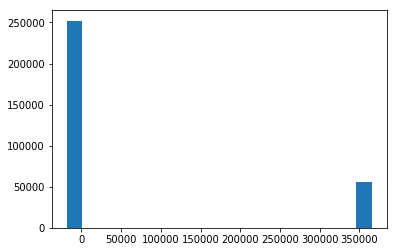

In [27]:
plt.hist(df_train['DAYS_EMPLOYED'],bins=20);

In [28]:
x_train[x_train.DAYS_EMPLOYED > 300000].shape

(86278, 291)

In [29]:
x_train[x_train.DAYS_EMPLOYED > 300000].DAYS_EMPLOYED.unique()

array([365243.        , 307998.82376913, 316652.62956821, 338962.39908966,
       318425.65296529])

Разобьем DAYS_EMPLOYED на две колонки: 1) до 300 000 (остальное Impute-им) 2) более 300 000 (остальное =0), так как большие значения с одной стороны похожи на выбросы, но с другой их достаточно много, и мы можем потерять значимые данные простым импьютом

In [30]:
x_train['DAYS_EMPLOYED_OUTLIERS'] = x_train.DAYS_EMPLOYED.apply(lambda x: x if x>300000 else np.nan).fillna(0)

m=np.mean(x_train.DAYS_EMPLOYED)
x_train['DAYS_EMPLOYED']=x_train.DAYS_EMPLOYED.apply(lambda x: x if x<300000 else m).fillna(0)

In [31]:
x_test['DAYS_EMPLOYED_OUTLIERS'] = x_test.DAYS_EMPLOYED.apply(lambda x: x if x>300000 else np.nan).fillna(0)

m=np.mean(x_test.DAYS_EMPLOYED)
x_test['DAYS_EMPLOYED']=x_test.DAYS_EMPLOYED.apply(lambda x: x if x<300000 else m).fillna(0)

Далее отскейлим признаки

In [32]:
x_train=pd.DataFrame(StandardScaler().fit_transform(x_train), columns=x_train.columns)
x_test=pd.DataFrame(StandardScaler().fit_transform(x_test), columns=x_test.columns)

In [33]:
x_train.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,COMMONAREA_AVG_1,COMMONAREA_MODE_1,COMMONAREA_MEDI_1,NONLIVINGAPARTMENTS_MODE_1,NONLIVINGAPARTMENTS_MEDI_1,NONLIVINGAPARTMENTS_AVG_1,LIVINGAPARTMENTS_MODE_1,LIVINGAPARTMENTS_MEDI_1,LIVINGAPARTMENTS_AVG_1,FLOORSMIN_AVG_1,FLOORSMIN_MODE_1,FLOORSMIN_MEDI_1,YEARS_BUILD_MEDI_1,YEARS_BUILD_AVG_1,YEARS_BUILD_MODE_1,OWN_CAR_AGE_1,LANDAREA_MEDI_1,LANDAREA_AVG_1,LANDAREA_MODE_1,BASEMENTAREA_MEDI_1,BASEMENTAREA_MODE_1,BASEMENTAREA_AVG_1,EXT_SOURCE_1_1,NONLIVINGAREA_AVG_1,NONLIVINGAREA_MODE_1,NONLIVINGAREA_MEDI_1,ELEVATORS_MODE_1,ELEVATORS_MEDI_1,ELEVATORS_AVG_1,APARTMENTS_AVG_1,APARTMENTS_MODE_1,APARTMENTS_MEDI_1,ENTRANCES_MEDI_1,ENTRANCES_MODE_1,ENTRANCES_AVG_1,LIVINGAREA_AVG_1,LIVINGAREA_MEDI_1,LIVINGAREA_MODE_1,FLOORSMAX_AVG_1,FLOORSMAX_MEDI_1,FLOORSMAX_MODE_1,YEARS_BEGINEXPLUATATION_MEDI_1,YEARS_BEGINEXPLUATATION_AVG_1,YEARS_BEGINEXPLUATATION_MODE_1,TOTALAREA_MODE_1,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core sta

In [88]:
# Find importance
t_start = time.time()
rnd_clf = RandomForestClassifier(n_jobs=-1, random_state=42)
rnd_clf.fit(x_train, y_train)

t_end = time.time()
print('time for training is {} minutes'.format((t_end - t_start)/60))

/Users/mary/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


time for training is 0.5698480168978374 minutes


In [89]:
perc=0.02
rfc_imp_frame=pd.DataFrame({
    'column':x_train.columns, 
    'importance':rnd_clf.feature_importances_}).sort_values(by='importance', ascending=False)
print('Признаков важностью >= {} всего '.format(perc) + str(rfc_imp_frame[rfc_imp_frame.importance >= perc].shape[0]))
rfc_imp_features = rfc_imp_frame[rfc_imp_frame.importance >= perc].column
rfc_imp_frame[rfc_imp_frame.importance >= perc]

Признаков важностью >= 0.02 всего 9


,column,importance
142,FLOORSMAX_AVG_1,0.04
133,APARTMENTS_AVG_1,0.04
152,CODE_GENDER_M,0.03
132,ELEVATORS_AVG_1,0.03
29,EXT_SOURCE_3,0.02
75,OBS_60_CNT_SOCIAL_CIRCLE,0.02
151,CODE_GENDER_F,0.02
28,EXT_SOURCE_2,0.02
177,NAME_FAMILY_STATUS_Married,0.02


Теперь построим модель LGBM на всех признаках после предобработки и настроим параметры

In [40]:
def gridsearch_cv(model, param_grid, x_train=x_train, y_train=y_train):
    grid_search = GridSearchCV(model, param_grid, cv=4, scoring='accuracy')
    t_start = time.time()
    grid_search.fit(x_train, y_train)
    t_end = time.time()
    print('model {} best accuracy score is {}'.format(model.__class__.__name__, grid_search.best_score_))
    print('time for training is {} minutes'.format((t_end - t_start)/60))
    print(grid_search.best_score_)
    print(grid_search.best_estimator_)
    print(grid_search.best_params_)
    return grid_search

In [42]:
# LGBM

param_grid = {'n_estimators': [100, 300, 500]}
light = gridsearch_cv(lgb.LGBMClassifier(random_state=42), param_grid)

model LGBMClassifier best accuracy score is 0.954645790736011
time for training is 44.888414899508156 minutes
0.954645790736011
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
{'n_estimators': 100}


In [43]:
param_grid = {'learning_rate': [0.01, 0.05, 0.1]}
light = gridsearch_cv(lgb.LGBMClassifier(n_jobs=-1, random_state=42, n_estimators=100), param_grid)

model LGBMClassifier best accuracy score is 0.9549694714276618
time for training is 28.56786876519521 minutes
0.9549694714276618
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
{'learning_rate': 0.05}


In [44]:
param_grid = {'max_depth': [3, 4, 5]}
light = gridsearch_cv(lgb.LGBMClassifier(n_jobs=-1, random_state=42, n_estimators=100, learning_rate=0.05), 
                      param_grid)

model LGBMClassifier best accuracy score is 0.9546670156993979
time for training is 22.908858728408813 minutes
0.9546670156993979
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
{'max_depth': 5}


In [47]:
param_grid = {'reg_alpha': [0.3, 0.7, 1, 1.5, 3]}
light = gridsearch_cv(lgb.LGBMClassifier(n_jobs=-1, random_state=42, n_estimators=100, learning_rate=0.05,
                                  max_depth=5), param_grid)

model LGBMClassifier best accuracy score is 0.9546758594341425
time for training is 33.354721295833585 minutes
0.9546758594341425
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=1.5, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
{'reg_alpha': 1.5}


In [49]:
param_grid = {'reg_lambda': [0.3, 0.7, 1, 1.5, 3]}
light = gridsearch_cv(lgb.LGBMClassifier(n_jobs=-1, random_state=42, n_estimators=100, learning_rate=0.05,
                                  max_depth=5, reg_alpha=1.5), param_grid)

model LGBMClassifier best accuracy score is 0.954645790736011
time for training is 43.72821441491445 minutes
0.954645790736011
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=1.5, reg_lambda=0.7, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
{'reg_lambda': 0.7}


Тут, несмотря на то, что получили оптимальный коэффициент при регуляризации L1 равный 0.7, заметим, что качество на кроссвалидации стало ниже, чем вовсе без регуляризации L1 (предыдущий шаг). Поэтому оптимальнен reg_lambda=0:

In [50]:
# Just as experiment: trying more trees with different regularization degree, look at cv
param_grid = {'reg_alpha': [0.5, 1, 3]}
light = gridsearch_cv(lgb.LGBMClassifier(n_jobs=-1, random_state=42, n_estimators=500, learning_rate=0.05,
                                  max_depth=5), param_grid)

model LGBMClassifier best accuracy score is 0.9545891908336458
time for training is 53.870874118804934 minutes
0.9545891908336458
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=1, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
{'reg_alpha': 1}


In [187]:
# CatBoost

param_grid = {'iterations': [45, 50, 60]}
cbc = gridsearch_cv(CatBoostClassifier(random_state=42, learning_rate=0.1), param_grid)

0:	learn: 0.5533627	total: 822ms	remaining: 36.2s
1:	learn: 0.4510274	total: 1.71s	remaining: 36.8s
2:	learn: 0.3653573	total: 2.78s	remaining: 38.9s
3:	learn: 0.2928687	total: 3.88s	remaining: 39.8s
4:	learn: 0.2439925	total: 4.66s	remaining: 37.3s
5:	learn: 0.2072818	total: 5.46s	remaining: 35.5s
6:	learn: 0.1741452	total: 6.22s	remaining: 33.8s
7:	learn: 0.1467473	total: 6.98s	remaining: 32.3s
8:	learn: 0.1255638	total: 7.71s	remaining: 30.8s
9:	learn: 0.1087448	total: 8.45s	remaining: 29.6s
10:	learn: 0.0932903	total: 9.21s	remaining: 28.5s
11:	learn: 0.0797148	total: 9.92s	remaining: 27.3s
12:	learn: 0.0678551	total: 10.6s	remaining: 26s
13:	learn: 0.0595747	total: 11.3s	remaining: 25.1s
14:	learn: 0.0528807	total: 12.1s	remaining: 24.1s
15:	learn: 0.0472448	total: 12.7s	remaining: 23.1s
16:	learn: 0.0416674	total: 13.6s	remaining: 22.4s
17:	learn: 0.0369682	total: 14.3s	remaining: 21.5s
18:	learn: 0.0333152	total: 15.1s	remaining: 20.6s
19:	learn: 0.0295763	total: 15.8s	remaining

28:	learn: 0.1807697	total: 17.5s	remaining: 9.67s
29:	learn: 0.1798087	total: 18.1s	remaining: 9.03s
30:	learn: 0.1794304	total: 18.6s	remaining: 8.38s
31:	learn: 0.1785627	total: 19.3s	remaining: 7.83s
32:	learn: 0.1782727	total: 19.9s	remaining: 7.23s
33:	learn: 0.1768804	total: 20.5s	remaining: 6.63s
34:	learn: 0.1766094	total: 21.1s	remaining: 6.03s
35:	learn: 0.1764296	total: 21.5s	remaining: 5.38s
36:	learn: 0.1761193	total: 22.1s	remaining: 4.77s
37:	learn: 0.1759197	total: 22.5s	remaining: 4.15s
38:	learn: 0.1757318	total: 23.1s	remaining: 3.55s
39:	learn: 0.1754845	total: 23.7s	remaining: 2.96s
40:	learn: 0.1753192	total: 24.2s	remaining: 2.36s
41:	learn: 0.1744427	total: 24.7s	remaining: 1.76s
42:	learn: 0.1742394	total: 25.2s	remaining: 1.17s
43:	learn: 0.1741268	total: 25.7s	remaining: 584ms
44:	learn: 0.1740181	total: 26.2s	remaining: 0us
0:	learn: 0.5533627	total: 696ms	remaining: 34.1s
1:	learn: 0.4510274	total: 1.42s	remaining: 34.2s
2:	learn: 0.3653573	total: 2.07s	re

46:	learn: 0.1731974	total: 27.9s	remaining: 1.78s
47:	learn: 0.1730907	total: 28.4s	remaining: 1.18s
48:	learn: 0.1729398	total: 28.9s	remaining: 591ms
49:	learn: 0.1728581	total: 29.4s	remaining: 0us
0:	learn: 0.6051035	total: 634ms	remaining: 31.1s
1:	learn: 0.5157609	total: 1.33s	remaining: 32s
2:	learn: 0.4479205	total: 2.05s	remaining: 32.1s
3:	learn: 0.3901922	total: 2.78s	remaining: 32s
4:	learn: 0.3451466	total: 3.47s	remaining: 31.3s
5:	learn: 0.3149930	total: 4.19s	remaining: 30.8s
6:	learn: 0.2895692	total: 4.81s	remaining: 29.6s
7:	learn: 0.2708945	total: 5.48s	remaining: 28.8s
8:	learn: 0.2560107	total: 6.21s	remaining: 28.3s
9:	learn: 0.2450868	total: 6.86s	remaining: 27.4s
10:	learn: 0.2345203	total: 7.54s	remaining: 26.7s
11:	learn: 0.2251615	total: 8.11s	remaining: 25.7s
12:	learn: 0.2193424	total: 8.79s	remaining: 25s
13:	learn: 0.2129976	total: 9.4s	remaining: 24.2s
14:	learn: 0.2070315	total: 10s	remaining: 23.4s
15:	learn: 0.2014782	total: 10.6s	remaining: 22.6s
1

49:	learn: 0.1728641	total: 29.1s	remaining: 5.83s
50:	learn: 0.1727505	total: 29.7s	remaining: 5.23s
51:	learn: 0.1726221	total: 30.2s	remaining: 4.64s
52:	learn: 0.1725224	total: 30.6s	remaining: 4.04s
53:	learn: 0.1723636	total: 31.2s	remaining: 3.46s
54:	learn: 0.1722569	total: 31.7s	remaining: 2.89s
55:	learn: 0.1720586	total: 32.3s	remaining: 2.31s
56:	learn: 0.1719633	total: 32.8s	remaining: 1.73s
57:	learn: 0.1718888	total: 33.3s	remaining: 1.15s
58:	learn: 0.1718203	total: 33.8s	remaining: 572ms
59:	learn: 0.1716899	total: 34.4s	remaining: 0us
0:	learn: 0.5747430	total: 716ms	remaining: 42.3s
1:	learn: 0.4881267	total: 1.44s	remaining: 41.7s
2:	learn: 0.4161916	total: 2.21s	remaining: 41.9s
3:	learn: 0.3664451	total: 2.99s	remaining: 41.9s
4:	learn: 0.3358891	total: 3.78s	remaining: 41.6s
5:	learn: 0.3028200	total: 4.45s	remaining: 40s
6:	learn: 0.2798858	total: 5.16s	remaining: 39.1s
7:	learn: 0.2642800	total: 5.8s	remaining: 37.7s
8:	learn: 0.2506945	total: 6.52s	remaining: 

32:	learn: 0.1445761	total: 27.6s	remaining: 14.2s
33:	learn: 0.1443424	total: 28.3s	remaining: 13.3s
34:	learn: 0.1440972	total: 29.1s	remaining: 12.5s
35:	learn: 0.1439024	total: 29.9s	remaining: 11.6s
36:	learn: 0.1437121	total: 30.5s	remaining: 10.7s
37:	learn: 0.1434995	total: 31.4s	remaining: 9.92s
38:	learn: 0.1432590	total: 32.1s	remaining: 9.06s
39:	learn: 0.1431709	total: 32.7s	remaining: 8.18s
40:	learn: 0.1423843	total: 33.5s	remaining: 7.36s
41:	learn: 0.1422762	total: 34.3s	remaining: 6.53s
42:	learn: 0.1421725	total: 35s	remaining: 5.7s
43:	learn: 0.1420630	total: 35.7s	remaining: 4.87s
44:	learn: 0.1419701	total: 36.3s	remaining: 4.04s
45:	learn: 0.1418321	total: 37s	remaining: 3.22s
46:	learn: 0.1417472	total: 37.6s	remaining: 2.4s
47:	learn: 0.1416526	total: 38.4s	remaining: 1.6s
48:	learn: 0.1415969	total: 39s	remaining: 796ms
49:	learn: 0.1415275	total: 39.6s	remaining: 0us
model CatBoostClassifier best accuracy score is 0.9542814288645353
time for training is 21.91

In [191]:
from catboost import CatBoostClassifier
param_grid = {'depth': [2, 3, 4, 5]}
cbc = gridsearch_cv(CatBoostClassifier(random_state=42, learning_rate=0.1, iterations=50), param_grid)

0:	learn: 0.5906048	total: 403ms	remaining: 19.7s
1:	learn: 0.5710048	total: 874ms	remaining: 21s
2:	learn: 0.4974323	total: 1.34s	remaining: 21s
3:	learn: 0.4842141	total: 1.75s	remaining: 20.1s
4:	learn: 0.4360348	total: 2.17s	remaining: 19.6s
5:	learn: 0.3818481	total: 2.61s	remaining: 19.2s
6:	learn: 0.3444607	total: 3.04s	remaining: 18.7s
7:	learn: 0.3154026	total: 3.47s	remaining: 18.2s
8:	learn: 0.2770055	total: 3.97s	remaining: 18.1s
9:	learn: 0.2489443	total: 4.35s	remaining: 17.4s
10:	learn: 0.2322611	total: 4.75s	remaining: 16.8s
11:	learn: 0.2224946	total: 5.12s	remaining: 16.2s
12:	learn: 0.2018698	total: 5.55s	remaining: 15.8s
13:	learn: 0.1862473	total: 5.96s	remaining: 15.3s
14:	learn: 0.1654323	total: 6.36s	remaining: 14.8s
15:	learn: 0.1524562	total: 6.77s	remaining: 14.4s
16:	learn: 0.1401004	total: 7.21s	remaining: 14s
17:	learn: 0.1299457	total: 7.65s	remaining: 13.6s
18:	learn: 0.1202093	total: 8.05s	remaining: 13.1s
19:	learn: 0.1089072	total: 8.41s	remaining: 12

13:	learn: 0.2975484	total: 6.26s	remaining: 16.1s
14:	learn: 0.2877832	total: 6.67s	remaining: 15.6s
15:	learn: 0.2826991	total: 7.09s	remaining: 15.1s
16:	learn: 0.2782956	total: 7.46s	remaining: 14.5s
17:	learn: 0.2745565	total: 7.84s	remaining: 13.9s
18:	learn: 0.2706312	total: 8.28s	remaining: 13.5s
19:	learn: 0.2580503	total: 8.68s	remaining: 13s
20:	learn: 0.2507783	total: 9.16s	remaining: 12.7s
21:	learn: 0.2481920	total: 9.56s	remaining: 12.2s
22:	learn: 0.2417318	total: 9.96s	remaining: 11.7s
23:	learn: 0.2397379	total: 10.4s	remaining: 11.2s
24:	learn: 0.2379915	total: 10.7s	remaining: 10.7s
25:	learn: 0.2364088	total: 11.1s	remaining: 10.3s
26:	learn: 0.2318932	total: 11.5s	remaining: 9.8s
27:	learn: 0.2245996	total: 11.9s	remaining: 9.33s
28:	learn: 0.2231775	total: 12.3s	remaining: 8.87s
29:	learn: 0.2170514	total: 12.6s	remaining: 8.41s
30:	learn: 0.2159005	total: 13s	remaining: 7.97s
31:	learn: 0.2149341	total: 13.4s	remaining: 7.55s
32:	learn: 0.2141212	total: 13.8s	re

26:	learn: 0.2013880	total: 13s	remaining: 11s
27:	learn: 0.1981075	total: 13.4s	remaining: 10.5s
28:	learn: 0.1952955	total: 13.9s	remaining: 10.1s
29:	learn: 0.1945099	total: 14.3s	remaining: 9.52s
30:	learn: 0.1938018	total: 14.7s	remaining: 9.01s
31:	learn: 0.1912102	total: 15.1s	remaining: 8.48s
32:	learn: 0.1905881	total: 15.5s	remaining: 7.99s
33:	learn: 0.1900996	total: 15.9s	remaining: 7.47s
34:	learn: 0.1886357	total: 16.4s	remaining: 7.02s
35:	learn: 0.1882023	total: 16.7s	remaining: 6.51s
36:	learn: 0.1878265	total: 17.2s	remaining: 6.03s
37:	learn: 0.1874666	total: 17.6s	remaining: 5.55s
38:	learn: 0.1871906	total: 18.1s	remaining: 5.09s
39:	learn: 0.1868600	total: 18.5s	remaining: 4.62s
40:	learn: 0.1840849	total: 18.9s	remaining: 4.14s
41:	learn: 0.1838233	total: 19.3s	remaining: 3.68s
42:	learn: 0.1835975	total: 19.8s	remaining: 3.23s
43:	learn: 0.1833344	total: 20.6s	remaining: 2.81s
44:	learn: 0.1820261	total: 21.1s	remaining: 2.35s
45:	learn: 0.1818449	total: 21.5s	r

39:	learn: 0.1797394	total: 17.9s	remaining: 4.46s
40:	learn: 0.1794872	total: 18.3s	remaining: 4.01s
41:	learn: 0.1793013	total: 18.6s	remaining: 3.55s
42:	learn: 0.1791127	total: 19s	remaining: 3.09s
43:	learn: 0.1789578	total: 19.4s	remaining: 2.64s
44:	learn: 0.1787914	total: 19.7s	remaining: 2.19s
45:	learn: 0.1786498	total: 20.1s	remaining: 1.75s
46:	learn: 0.1785288	total: 20.4s	remaining: 1.3s
47:	learn: 0.1783461	total: 20.8s	remaining: 869ms
48:	learn: 0.1782363	total: 21.2s	remaining: 433ms
49:	learn: 0.1780067	total: 21.6s	remaining: 0us
0:	learn: 0.5924384	total: 646ms	remaining: 31.7s
1:	learn: 0.5222475	total: 1.38s	remaining: 33.2s
2:	learn: 0.4754864	total: 1.94s	remaining: 30.3s
3:	learn: 0.4355336	total: 2.68s	remaining: 30.8s
4:	learn: 0.3940716	total: 3.46s	remaining: 31.1s
5:	learn: 0.3591963	total: 4.16s	remaining: 30.5s
6:	learn: 0.3317610	total: 4.75s	remaining: 29.2s
7:	learn: 0.3107274	total: 5.29s	remaining: 27.8s
8:	learn: 0.2917256	total: 5.82s	remaining: 

2:	learn: 0.4423666	total: 2.15s	remaining: 33.6s
3:	learn: 0.3862340	total: 2.79s	remaining: 32.1s
4:	learn: 0.3522225	total: 3.38s	remaining: 30.4s
5:	learn: 0.3267562	total: 4.03s	remaining: 29.6s
6:	learn: 0.3011784	total: 4.62s	remaining: 28.4s
7:	learn: 0.2827402	total: 5.26s	remaining: 27.6s
8:	learn: 0.2662103	total: 5.77s	remaining: 26.3s
9:	learn: 0.2560730	total: 6.39s	remaining: 25.6s
10:	learn: 0.2449062	total: 7.04s	remaining: 25s
11:	learn: 0.2337490	total: 7.59s	remaining: 24s
12:	learn: 0.2247895	total: 8.29s	remaining: 23.6s
13:	learn: 0.2155090	total: 8.91s	remaining: 22.9s
14:	learn: 0.2113341	total: 9.39s	remaining: 21.9s
15:	learn: 0.2073112	total: 10s	remaining: 21.3s
16:	learn: 0.2035644	total: 10.5s	remaining: 20.5s
17:	learn: 0.1998449	total: 11.1s	remaining: 19.8s
18:	learn: 0.1968789	total: 11.6s	remaining: 19s
19:	learn: 0.1941639	total: 12.2s	remaining: 18.4s
20:	learn: 0.1921266	total: 12.8s	remaining: 17.6s
21:	learn: 0.1907247	total: 13.2s	remaining: 16

15:	learn: 0.1766207	total: 13.1s	remaining: 27.8s
16:	learn: 0.1719183	total: 13.8s	remaining: 26.8s
17:	learn: 0.1692896	total: 14.6s	remaining: 25.9s
18:	learn: 0.1659216	total: 15.2s	remaining: 24.8s
19:	learn: 0.1624046	total: 15.8s	remaining: 23.6s
20:	learn: 0.1592672	total: 16.5s	remaining: 22.8s
21:	learn: 0.1573979	total: 17.2s	remaining: 21.9s
22:	learn: 0.1555734	total: 17.9s	remaining: 21s
23:	learn: 0.1540844	total: 18.6s	remaining: 20.1s
24:	learn: 0.1530703	total: 19.3s	remaining: 19.3s
25:	learn: 0.1522669	total: 20s	remaining: 18.4s
26:	learn: 0.1516087	total: 20.7s	remaining: 17.6s
27:	learn: 0.1504512	total: 21.3s	remaining: 16.7s
28:	learn: 0.1498098	total: 22s	remaining: 15.9s
29:	learn: 0.1487304	total: 22.6s	remaining: 15.1s
30:	learn: 0.1471475	total: 23.3s	remaining: 14.3s
31:	learn: 0.1467768	total: 23.9s	remaining: 13.5s
32:	learn: 0.1464742	total: 24.6s	remaining: 12.7s
33:	learn: 0.1461930	total: 25.2s	remaining: 11.8s
34:	learn: 0.1457998	total: 25.7s	rem

In [194]:
from catboost import CatBoostClassifier
param_grid = {'learning_rate': [1, 0.1, 0.01, 0.001]}
cbc = gridsearch_cv(CatBoostClassifier(random_state=42, iterations=50, depth=5), param_grid)

0:	learn: 0.3682210	total: 680ms	remaining: 33.3s
1:	learn: 0.2770441	total: 1.31s	remaining: 31.6s
2:	learn: 0.1904520	total: 1.95s	remaining: 30.6s
3:	learn: 0.1403542	total: 2.56s	remaining: 29.5s
4:	learn: 0.0917377	total: 3.22s	remaining: 29s
5:	learn: 0.0572673	total: 3.85s	remaining: 28.3s
6:	learn: 0.0446624	total: 4.51s	remaining: 27.7s
7:	learn: 0.0364318	total: 5.06s	remaining: 26.6s
8:	learn: 0.0233290	total: 5.71s	remaining: 26s
9:	learn: 0.0181594	total: 6.21s	remaining: 24.8s
10:	learn: 0.0131818	total: 6.79s	remaining: 24.1s
11:	learn: 0.0098284	total: 7.27s	remaining: 23s
12:	learn: 0.0081005	total: 7.81s	remaining: 22.2s
13:	learn: 0.0059045	total: 8.29s	remaining: 21.3s
14:	learn: 0.0042541	total: 8.7s	remaining: 20.3s
15:	learn: 0.0041198	total: 9.07s	remaining: 19.3s
16:	learn: 0.0040401	total: 9.45s	remaining: 18.3s
17:	learn: 0.0035069	total: 9.87s	remaining: 17.5s
18:	learn: 0.0023830	total: 10.3s	remaining: 16.8s
19:	learn: 0.0022515	total: 10.7s	remaining: 16s

13:	learn: 0.1759103	total: 8.15s	remaining: 21s
14:	learn: 0.1752324	total: 8.66s	remaining: 20.2s
15:	learn: 0.1747104	total: 9.12s	remaining: 19.4s
16:	learn: 0.1741897	total: 9.57s	remaining: 18.6s
17:	learn: 0.1738333	total: 10s	remaining: 17.8s
18:	learn: 0.1734078	total: 10.4s	remaining: 17s
19:	learn: 0.1730265	total: 10.9s	remaining: 16.4s
20:	learn: 0.1726448	total: 11.3s	remaining: 15.7s
21:	learn: 0.1724187	total: 11.9s	remaining: 15.1s
22:	learn: 0.1718917	total: 12.4s	remaining: 14.5s
23:	learn: 0.1715926	total: 12.8s	remaining: 13.9s
24:	learn: 0.1710674	total: 13.3s	remaining: 13.3s
25:	learn: 0.1708407	total: 14.2s	remaining: 13.1s
26:	learn: 0.1706317	total: 15.1s	remaining: 12.8s
27:	learn: 0.1702467	total: 15.7s	remaining: 12.3s
28:	learn: 0.1700521	total: 16.1s	remaining: 11.7s
29:	learn: 0.1697547	total: 16.7s	remaining: 11.2s
30:	learn: 0.1694563	total: 17.2s	remaining: 10.5s
31:	learn: 0.1692994	total: 17.7s	remaining: 9.94s
32:	learn: 0.1691790	total: 18.1s	rem

26:	learn: 0.1838027	total: 15.1s	remaining: 12.8s
27:	learn: 0.1832090	total: 15.5s	remaining: 12.2s
28:	learn: 0.1818408	total: 16s	remaining: 11.6s
29:	learn: 0.1806024	total: 16.6s	remaining: 11s
30:	learn: 0.1801861	total: 17s	remaining: 10.4s
31:	learn: 0.1797787	total: 17.5s	remaining: 9.85s
32:	learn: 0.1794068	total: 18s	remaining: 9.26s
33:	learn: 0.1790618	total: 18.5s	remaining: 8.71s
34:	learn: 0.1787930	total: 18.9s	remaining: 8.11s
35:	learn: 0.1785395	total: 19.3s	remaining: 7.52s
36:	learn: 0.1783054	total: 19.8s	remaining: 6.95s
37:	learn: 0.1780435	total: 20.2s	remaining: 6.39s
38:	learn: 0.1777372	total: 20.7s	remaining: 5.85s
39:	learn: 0.1775086	total: 21.2s	remaining: 5.31s
40:	learn: 0.1773594	total: 21.7s	remaining: 4.76s
41:	learn: 0.1772079	total: 22.1s	remaining: 4.21s
42:	learn: 0.1770482	total: 22.6s	remaining: 3.68s
43:	learn: 0.1759335	total: 23.1s	remaining: 3.15s
44:	learn: 0.1758256	total: 23.5s	remaining: 2.61s
45:	learn: 0.1757132	total: 24s	remaini

39:	learn: 0.3980812	total: 27.8s	remaining: 6.96s
40:	learn: 0.3930644	total: 28.5s	remaining: 6.26s
41:	learn: 0.3886771	total: 29.1s	remaining: 5.55s
42:	learn: 0.3848664	total: 29.7s	remaining: 4.83s
43:	learn: 0.3808794	total: 30.3s	remaining: 4.13s
44:	learn: 0.3768072	total: 30.9s	remaining: 3.43s
45:	learn: 0.3737896	total: 31.5s	remaining: 2.74s
46:	learn: 0.3700010	total: 32.1s	remaining: 2.05s
47:	learn: 0.3658788	total: 32.8s	remaining: 1.36s
48:	learn: 0.3621311	total: 33.5s	remaining: 684ms
49:	learn: 0.3583019	total: 34.1s	remaining: 0us
0:	learn: 0.6786200	total: 637ms	remaining: 31.2s
1:	learn: 0.6676742	total: 1.21s	remaining: 29s
2:	learn: 0.6541105	total: 1.8s	remaining: 28.1s
3:	learn: 0.6412399	total: 2.41s	remaining: 27.7s
4:	learn: 0.6280686	total: 2.99s	remaining: 26.9s
5:	learn: 0.6202199	total: 3.55s	remaining: 26s
6:	learn: 0.6088273	total: 4.14s	remaining: 25.5s
7:	learn: 0.5994098	total: 4.76s	remaining: 25s
8:	learn: 0.5882565	total: 5.34s	remaining: 24.3

2:	learn: 0.6889566	total: 1.92s	remaining: 30.2s
3:	learn: 0.6877240	total: 2.56s	remaining: 29.4s
4:	learn: 0.6861801	total: 3.16s	remaining: 28.4s
5:	learn: 0.6849719	total: 3.83s	remaining: 28.1s
6:	learn: 0.6835510	total: 4.45s	remaining: 27.3s
7:	learn: 0.6820254	total: 5.03s	remaining: 26.4s
8:	learn: 0.6808226	total: 5.66s	remaining: 25.8s
9:	learn: 0.6796191	total: 6.23s	remaining: 24.9s
10:	learn: 0.6781355	total: 6.8s	remaining: 24.1s
11:	learn: 0.6769402	total: 7.39s	remaining: 23.4s
12:	learn: 0.6757411	total: 7.98s	remaining: 22.7s
13:	learn: 0.6745643	total: 8.59s	remaining: 22.1s
14:	learn: 0.6731685	total: 9.21s	remaining: 21.5s
15:	learn: 0.6719060	total: 9.79s	remaining: 20.8s
16:	learn: 0.6705175	total: 10.4s	remaining: 20.2s
17:	learn: 0.6690790	total: 11s	remaining: 19.5s
18:	learn: 0.6677052	total: 11.6s	remaining: 18.9s
19:	learn: 0.6665620	total: 12.1s	remaining: 18.2s
20:	learn: 0.6651839	total: 12.7s	remaining: 17.5s
21:	learn: 0.6640558	total: 13.3s	remainin

15:	learn: 0.1766207	total: 12.9s	remaining: 27.3s
16:	learn: 0.1719183	total: 13.6s	remaining: 26.4s
17:	learn: 0.1692896	total: 14.4s	remaining: 25.5s
18:	learn: 0.1659216	total: 15s	remaining: 24.5s
19:	learn: 0.1624046	total: 15.6s	remaining: 23.4s
20:	learn: 0.1592672	total: 16.4s	remaining: 22.7s
21:	learn: 0.1573979	total: 17.2s	remaining: 21.9s
22:	learn: 0.1555734	total: 17.9s	remaining: 21s
23:	learn: 0.1540844	total: 18.6s	remaining: 20.1s
24:	learn: 0.1530703	total: 19.3s	remaining: 19.3s
25:	learn: 0.1522669	total: 20s	remaining: 18.4s
26:	learn: 0.1516087	total: 20.6s	remaining: 17.6s
27:	learn: 0.1504512	total: 21.2s	remaining: 16.7s
28:	learn: 0.1498098	total: 21.9s	remaining: 15.8s
29:	learn: 0.1487304	total: 22.5s	remaining: 15s
30:	learn: 0.1471475	total: 23.2s	remaining: 14.2s
31:	learn: 0.1467768	total: 23.9s	remaining: 13.4s
32:	learn: 0.1464742	total: 24.5s	remaining: 12.6s
33:	learn: 0.1461930	total: 25.1s	remaining: 11.8s
34:	learn: 0.1457998	total: 25.7s	remai

In [74]:
x_train['TARGET']=y_train
corrs = x_train.corr()['TARGET'].sort_values()
x_train.drop(columns='TARGET', inplace=True)

print('Most Positive Correlations:\n', corrs.tail(20))
print('\nMost Negative Correlations:\n', corrs.head(20))

Most Positive Correlations:
 FONDKAPREMONT_MODE_nan                              0.06
LIVE_CITY_NOT_WORK_CITY                             0.06
WALLSMATERIAL_MODE_nan                              0.08
HOUSETYPE_MODE_nan                                  0.08
OCCUPATION_TYPE_Laborers                            0.08
EMERGENCYSTATE_MODE_nan                             0.08
REG_CITY_NOT_LIVE_CITY                              0.08
FLAG_DOCUMENT_3                                     0.09
FLAG_EMP_PHONE                                      0.09
DAYS_ID_PUBLISH                                     0.09
DAYS_REGISTRATION                                   0.10
REG_CITY_NOT_WORK_CITY                              0.10
NAME_EDUCATION_TYPE_Secondary / secondary special   0.10
CODE_GENDER_M                                       0.11
DAYS_LAST_PHONE_CHANGE                              0.11
NAME_INCOME_TYPE_Working                            0.12
REGION_RATING_CLIENT                                0.12
RE

In [75]:
most_corrs=corrs.apply(lambda x: x if abs(x)>=0.11 else np.nan)[:-1].copy().reset_index() #[:-1] - TARGET removal
most_corrs=most_corrs[~most_corrs.TARGET.isna()]['index']
len(most_corrs)

9

Вывели признаки, у которых корреляция с TARGET по модулю >= 0.11 - запомним эти фичи. Далее построим полиномиальные фичи на основе наиболее коррелирующих с таргетом и добавим их к x_train и x_test.

In [76]:
poly_features = x_train[most_corrs].copy()
poly_features_test = x_test[most_corrs].copy()
                                  
poly_transformer = PolynomialFeatures(degree = 3)

poly_transformer.fit(poly_features)
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)

# Get names for new polynomial features
poly_names=poly_transformer.get_feature_names(input_features = list(most_corrs))

print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (565372, 220)


In [151]:
poly_features = pd.DataFrame(poly_features, columns = poly_names)
poly_features_test = pd.DataFrame(poly_features_test, columns = poly_names)
poly_features['TARGET'] = y_train

In [152]:
t_start=time.time()

# Find the correlations 
poly_corrs = poly_features.corr()['TARGET'].sort_values()[:-2] # without TARGET and column with ones
poly_features.drop(columns='TARGET', inplace=True)

print('time for training is {} minutes'.format((time.time() - t_start)/60))

# Display most negative and most positive
print(poly_corrs.head(20))
print(poly_corrs.tail(20))

time for training is 1.2779824495315553 minutes
NAME_INCOME_TYPE_Working^2                            -0.39
EXT_SOURCE_3                                          -0.29
EXT_SOURCE_2                                          -0.29
EXT_SOURCE_2 NAME_INCOME_TYPE_Working^2               -0.27
EXT_SOURCE_3 NAME_INCOME_TYPE_Working^2               -0.27
EXT_SOURCE_3^3                                        -0.22
NAME_EDUCATION_TYPE_Higher education^3                -0.22
NAME_EDUCATION_TYPE_Higher education^2                -0.21
EXT_SOURCE_2^3                                        -0.21
EXT_SOURCE_3 DAYS_BIRTH^2                             -0.20
EXT_SOURCE_3 EXT_SOURCE_2^2                           -0.20
EXT_SOURCE_1                                          -0.20
EXT_SOURCE_2 NAME_EDUCATION_TYPE_Higher education^2   -0.20
EXT_SOURCE_2 DAYS_BIRTH^2                             -0.19
EXT_SOURCE_3^2 EXT_SOURCE_2                           -0.18
EXT_SOURCE_2 DAYS_LAST_PHONE_CHANGE^2               

In [153]:
most_corrs_poly=poly_corrs.apply(lambda x: x if abs(x)>=0.10 else np.nan)[:-1].copy().reset_index() 
most_corrs_poly=most_corrs_poly[~most_corrs_poly.TARGET.isna()]['index']
len(most_corrs_poly)

63

На данный момент имеем 3 пула признаков: 
    * наиболее важные с точки зрения корреляции с целевой переменной;
    * наиболее важные с точки зрения корреляции с целевой переменной с учетом полиномиальных фичей;
    * наиболее важные по feature importance в RandomForest;
    
Сформируем последний пул: наиболее важные признаки по feature importance в RandomForest с учетом полиномиальных фичей

In [91]:
poly_rfc_features = x_train[rfc_imp_features].copy()
poly_rfc_features_test = x_test[rfc_imp_features].copy()

poly_rfc_transformer = PolynomialFeatures(degree = 3)

poly_rfc_transformer.fit(poly_rfc_features)
poly_rfc_features = poly_rfc_transformer.transform(poly_rfc_features)
poly_rfc_features_test = poly_rfc_transformer.transform(poly_rfc_features_test)

# Get names for new polynomial features
poly_rfc_names=poly_rfc_transformer.get_feature_names(input_features = list(rfc_imp_features))

print('Polynomial Features shape: ', poly_rfc_features.shape)

poly_rfc_features = pd.DataFrame(poly_rfc_features, columns = poly_rfc_names)
poly_rfc_features_test = pd.DataFrame(poly_rfc_features_test, columns = poly_rfc_names)

Polynomial Features shape:  (565372, 220)


In [92]:
# Find importance
t_start = time.time()
rnd_clf = RandomForestClassifier(n_jobs=-1, random_state=42)
rnd_clf.fit(poly_rfc_features, y_train)

t_end = time.time()
print('time for training is {} minutes'.format((t_end - t_start)/60))

/Users/mary/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


time for training is 0.9250700354576111 minutes


In [93]:
perc=0.02
poly_rfc_imp_frame=pd.DataFrame({
    'column':poly_rfc_features.columns, 
    'importance':rnd_clf.feature_importances_}).sort_values(by='importance', ascending=False)
print('Признаков важностью >= {} всего '.format(perc) + str(
    poly_rfc_imp_frame[poly_rfc_imp_frame.importance >= perc].shape[0]))

poly_rfc_imp_features = poly_rfc_imp_frame[poly_rfc_imp_frame.importance >= perc].column
poly_rfc_imp_frame[poly_rfc_imp_frame.importance >= perc]

Признаков важностью >= 0.02 всего 10


,column,importance
21,APARTMENTS_AVG_1 ELEVATORS_AVG_1,0.06
210,CODE_GENDER_F^3,0.04
54,NAME_FAMILY_STATUS_Married^2,0.04
65,FLOORSMAX_AVG_1 APARTMENTS_AVG_1 CODE_GENDER_M,0.03
34,ELEVATORS_AVG_1^2,0.02
143,CODE_GENDER_M ELEVATORS_AVG_1^2,0.02
13,FLOORSMAX_AVG_1 ELEVATORS_AVG_1,0.02
61,FLOORSMAX_AVG_1^2 CODE_GENDER_F,0.02
27,CODE_GENDER_M^2,0.02
136,CODE_GENDER_M^3,0.02


## 3. Применение нескольких моделей на разных признаках

Cпроектируйте эксперимент. Нужно заранее спланировать порядок перебора признаков и моделей. Потом только писать код. Обратный порядок вызывает необходимость переписывать существующий код, это трата времени.

Будем брать по одной модели и рассматривать пулы признаков, указанных ниже.

* Модели: XGBoost, LGBM, CatBoost, VotingClassifier - ансамбль трех предыдущих
* Признаки: 
    * Важные по корреляции с TARGET (из исходных обработанных) - "most_corrs";
    * Важные по корреляции с TARGET (после добавления полиномиальных) - "most_corrs_poly";
    * Важные по RandomForestClassifier (из исходных обработанных) - "rfc_imp_features";
    * Важные по RandomForestClassifier (после добавления полиномиальных) - "poly_rfc_imp_features".

In [154]:
f1 = x_train[most_corrs]
f2 = poly_features[most_corrs_poly]
f3 = x_train[rfc_imp_features]
f4 = poly_rfc_features[poly_rfc_imp_features]

In [168]:
def try_features(model):
    
    model_name = model.__class__.__name__
    scores_list=[]
    m=[f1, f2, f3, f4]
    n=['Initial_most_corr', 'Polynomial_most_corr', 'Initial_most_rfc_importance', 
       'Polynomial_most_rfc_importance']
    
    print('Process ' + model_name + '...')
    
    for features, name in zip(m, n):
        scores = cross_validate(model, features, y_train, scoring=['accuracy'], cv=5)['test_accuracy']
        scores_list.append(np.mean(scores))
        print(name)
        
    return np.array([[model_name]*4, n, scores_list]).T
    
    
def try_models(models):
    '''Required input - a list of models'''
    
    cols=['model_name', 'features', 'score']
    df=pd.DataFrame(columns=cols)
    for model in models:
        output = try_features(model)
        output = pd.DataFrame(output, columns=cols)
        
        df=pd.concat([df, output])
    
    return df

In [199]:
lgbm = lgb.LGBMClassifier(n_jobs=-1, random_state=42, n_estimators=100, learning_rate=0.05, max_depth=5, 
                           reg_alpha=1.5)
xgboost = xgb.XGBClassifier(n_jobs=-1, random_state=42, n_estimators=100, learning_rate=0.05, max_depth=5, 
                           reg_alpha=1.5)
catboost = CatBoostClassifier(random_state=42, iterations=50, depth=5, learning_rate=0.1)
ens = VotingClassifier(estimators=[('xgboost', xgboost), ('lgbm', lgbm), ('catboost', catboost)], voting='soft')

models_list = [xgboost, lgbm, catboost, ens]

models_scores = try_models(models_list)

0:	learn: 0.6573507	total: 87.3ms	remaining: 4.28s
1:	learn: 0.6276069	total: 170ms	remaining: 4.08s
2:	learn: 0.5955202	total: 247ms	remaining: 3.87s
3:	learn: 0.5743140	total: 325ms	remaining: 3.73s
4:	learn: 0.5559160	total: 404ms	remaining: 3.64s
5:	learn: 0.5274274	total: 487ms	remaining: 3.57s
6:	learn: 0.5129333	total: 576ms	remaining: 3.54s
7:	learn: 0.4898946	total: 662ms	remaining: 3.48s
8:	learn: 0.4760033	total: 740ms	remaining: 3.37s
9:	learn: 0.4632047	total: 813ms	remaining: 3.25s
10:	learn: 0.4460565	total: 886ms	remaining: 3.14s
11:	learn: 0.4371577	total: 952ms	remaining: 3.01s
12:	learn: 0.4274256	total: 1.02s	remaining: 2.9s
13:	learn: 0.4137447	total: 1.09s	remaining: 2.82s
14:	learn: 0.4053367	total: 1.16s	remaining: 2.71s
15:	learn: 0.3984424	total: 1.23s	remaining: 2.62s
16:	learn: 0.3914011	total: 1.3s	remaining: 2.53s
17:	learn: 0.3812535	total: 1.37s	remaining: 2.44s
18:	learn: 0.3757217	total: 1.44s	remaining: 2.35s
19:	learn: 0.3668794	total: 1.51s	remainin

13:	learn: 0.4556708	total: 996ms	remaining: 2.56s
14:	learn: 0.4452592	total: 1.07s	remaining: 2.5s
15:	learn: 0.4408662	total: 1.14s	remaining: 2.42s
16:	learn: 0.4370612	total: 1.2s	remaining: 2.34s
17:	learn: 0.4286565	total: 1.28s	remaining: 2.28s
18:	learn: 0.4213285	total: 1.35s	remaining: 2.2s
19:	learn: 0.4147423	total: 1.42s	remaining: 2.13s
20:	learn: 0.4086589	total: 1.48s	remaining: 2.05s
21:	learn: 0.4049278	total: 1.55s	remaining: 1.97s
22:	learn: 0.4008017	total: 1.62s	remaining: 1.9s
23:	learn: 0.3973892	total: 1.69s	remaining: 1.83s
24:	learn: 0.3953875	total: 1.75s	remaining: 1.75s
25:	learn: 0.3907416	total: 1.82s	remaining: 1.68s
26:	learn: 0.3870148	total: 1.89s	remaining: 1.61s
27:	learn: 0.3823927	total: 1.96s	remaining: 1.54s
28:	learn: 0.3799499	total: 2.02s	remaining: 1.47s
29:	learn: 0.3773683	total: 2.09s	remaining: 1.39s
30:	learn: 0.3737695	total: 2.16s	remaining: 1.32s
31:	learn: 0.3726646	total: 2.23s	remaining: 1.25s
32:	learn: 0.3703096	total: 2.3s	re

25:	learn: 0.3318500	total: 6.91s	remaining: 6.38s
26:	learn: 0.3311079	total: 7.19s	remaining: 6.12s
27:	learn: 0.3304891	total: 7.43s	remaining: 5.83s
28:	learn: 0.3296012	total: 7.68s	remaining: 5.56s
29:	learn: 0.3281034	total: 7.96s	remaining: 5.31s
30:	learn: 0.3275776	total: 8.25s	remaining: 5.06s
31:	learn: 0.3269390	total: 8.51s	remaining: 4.79s
32:	learn: 0.3262062	total: 8.76s	remaining: 4.51s
33:	learn: 0.3251645	total: 9.03s	remaining: 4.25s
34:	learn: 0.3245603	total: 9.27s	remaining: 3.97s
35:	learn: 0.3241520	total: 9.5s	remaining: 3.69s
36:	learn: 0.3235663	total: 9.77s	remaining: 3.43s
37:	learn: 0.3232033	total: 10s	remaining: 3.16s
38:	learn: 0.3227580	total: 10.2s	remaining: 2.89s
39:	learn: 0.3224688	total: 10.5s	remaining: 2.62s
40:	learn: 0.3219303	total: 10.7s	remaining: 2.36s
41:	learn: 0.3216593	total: 11s	remaining: 2.09s
42:	learn: 0.3214338	total: 11.2s	remaining: 1.83s
43:	learn: 0.3210257	total: 11.5s	remaining: 1.57s
44:	learn: 0.3207712	total: 11.8s	re

38:	learn: 0.3228873	total: 10.5s	remaining: 2.96s
39:	learn: 0.3226222	total: 10.7s	remaining: 2.68s
40:	learn: 0.3221198	total: 11s	remaining: 2.41s
41:	learn: 0.3205649	total: 11.2s	remaining: 2.14s
42:	learn: 0.3199244	total: 11.5s	remaining: 1.87s
43:	learn: 0.3194986	total: 11.8s	remaining: 1.6s
44:	learn: 0.3193212	total: 12.1s	remaining: 1.34s
45:	learn: 0.3189472	total: 12.3s	remaining: 1.07s
46:	learn: 0.3186392	total: 12.6s	remaining: 803ms
47:	learn: 0.3184377	total: 12.8s	remaining: 534ms
48:	learn: 0.3182296	total: 13.1s	remaining: 267ms
49:	learn: 0.3165902	total: 13.3s	remaining: 0us
0:	learn: 0.6368580	total: 83.5ms	remaining: 4.09s
1:	learn: 0.5882207	total: 176ms	remaining: 4.21s
2:	learn: 0.5571193	total: 253ms	remaining: 3.96s
3:	learn: 0.5214967	total: 330ms	remaining: 3.79s
4:	learn: 0.4915140	total: 407ms	remaining: 3.66s
5:	learn: 0.4654105	total: 481ms	remaining: 3.52s
6:	learn: 0.4471797	total: 558ms	remaining: 3.43s
7:	learn: 0.4256830	total: 683ms	remaining

0:	learn: 0.6454749	total: 82.4ms	remaining: 4.04s
1:	learn: 0.6122276	total: 155ms	remaining: 3.72s
2:	learn: 0.5851490	total: 228ms	remaining: 3.58s
3:	learn: 0.5607712	total: 309ms	remaining: 3.55s
4:	learn: 0.5399956	total: 386ms	remaining: 3.48s
5:	learn: 0.5126057	total: 459ms	remaining: 3.37s
6:	learn: 0.4907387	total: 529ms	remaining: 3.25s
7:	learn: 0.4691992	total: 600ms	remaining: 3.15s
8:	learn: 0.4504369	total: 672ms	remaining: 3.06s
9:	learn: 0.4384884	total: 753ms	remaining: 3.01s
10:	learn: 0.4242137	total: 829ms	remaining: 2.94s
11:	learn: 0.4132726	total: 903ms	remaining: 2.86s
12:	learn: 0.3995937	total: 977ms	remaining: 2.78s
13:	learn: 0.3875109	total: 1.05s	remaining: 2.69s
14:	learn: 0.3806319	total: 1.12s	remaining: 2.61s
15:	learn: 0.3706866	total: 1.19s	remaining: 2.54s
16:	learn: 0.3639718	total: 1.27s	remaining: 2.46s
17:	learn: 0.3570069	total: 1.35s	remaining: 2.4s
18:	learn: 0.3499237	total: 1.42s	remaining: 2.32s
19:	learn: 0.3426900	total: 1.5s	remainin

14:	learn: 0.3876175	total: 1.07s	remaining: 2.5s
15:	learn: 0.3810356	total: 1.14s	remaining: 2.42s
16:	learn: 0.3753473	total: 1.21s	remaining: 2.35s
17:	learn: 0.3668031	total: 1.28s	remaining: 2.28s
18:	learn: 0.3624108	total: 1.36s	remaining: 2.21s
19:	learn: 0.3584622	total: 1.43s	remaining: 2.14s
20:	learn: 0.3549887	total: 1.5s	remaining: 2.07s
21:	learn: 0.3516564	total: 1.57s	remaining: 2s
22:	learn: 0.3485197	total: 1.65s	remaining: 1.93s
23:	learn: 0.3460065	total: 1.72s	remaining: 1.87s
24:	learn: 0.3446918	total: 1.79s	remaining: 1.79s
25:	learn: 0.3426705	total: 1.86s	remaining: 1.72s
26:	learn: 0.3384509	total: 1.93s	remaining: 1.65s
27:	learn: 0.3365922	total: 2s	remaining: 1.57s
28:	learn: 0.3330292	total: 2.07s	remaining: 1.5s
29:	learn: 0.3318762	total: 2.14s	remaining: 1.43s
30:	learn: 0.3308620	total: 2.21s	remaining: 1.35s
31:	learn: 0.3298547	total: 2.27s	remaining: 1.28s
32:	learn: 0.3272649	total: 2.35s	remaining: 1.21s
33:	learn: 0.3249616	total: 2.41s	remain

28:	learn: 0.3321304	total: 2.05s	remaining: 1.48s
29:	learn: 0.3310232	total: 2.12s	remaining: 1.41s
30:	learn: 0.3278133	total: 2.19s	remaining: 1.34s
31:	learn: 0.3267323	total: 2.25s	remaining: 1.27s
32:	learn: 0.3257006	total: 2.32s	remaining: 1.2s
33:	learn: 0.3232289	total: 2.39s	remaining: 1.13s
34:	learn: 0.3222765	total: 2.46s	remaining: 1.05s
35:	learn: 0.3203859	total: 2.53s	remaining: 985ms
36:	learn: 0.3196590	total: 2.6s	remaining: 915ms
37:	learn: 0.3188633	total: 2.67s	remaining: 845ms
38:	learn: 0.3183675	total: 2.74s	remaining: 772ms
39:	learn: 0.3167375	total: 2.81s	remaining: 703ms
40:	learn: 0.3154970	total: 2.88s	remaining: 632ms
41:	learn: 0.3150673	total: 2.95s	remaining: 562ms
42:	learn: 0.3147626	total: 3.02s	remaining: 492ms
43:	learn: 0.3136021	total: 3.09s	remaining: 422ms
44:	learn: 0.3131101	total: 3.16s	remaining: 351ms
45:	learn: 0.3123147	total: 3.23s	remaining: 281ms
46:	learn: 0.3115950	total: 3.3s	remaining: 211ms
47:	learn: 0.3111410	total: 3.37s	

41:	learn: 0.3548605	total: 3.07s	remaining: 584ms
42:	learn: 0.3526203	total: 3.13s	remaining: 510ms
43:	learn: 0.3512135	total: 3.2s	remaining: 436ms
44:	learn: 0.3506160	total: 3.26s	remaining: 363ms
45:	learn: 0.3486193	total: 3.33s	remaining: 290ms
46:	learn: 0.3472763	total: 3.4s	remaining: 217ms
47:	learn: 0.3466255	total: 3.46s	remaining: 144ms
48:	learn: 0.3461560	total: 3.53s	remaining: 72ms
49:	learn: 0.3444707	total: 3.6s	remaining: 0us
0:	learn: 0.6611839	total: 80.7ms	remaining: 3.95s
1:	learn: 0.6348314	total: 151ms	remaining: 3.61s
2:	learn: 0.6128742	total: 223ms	remaining: 3.49s
3:	learn: 0.5945824	total: 294ms	remaining: 3.38s
4:	learn: 0.5737662	total: 388ms	remaining: 3.49s
5:	learn: 0.5500736	total: 467ms	remaining: 3.42s
6:	learn: 0.5327175	total: 539ms	remaining: 3.31s
7:	learn: 0.5211875	total: 605ms	remaining: 3.17s
8:	learn: 0.5037632	total: 673ms	remaining: 3.07s
9:	learn: 0.4912051	total: 740ms	remaining: 2.96s
10:	learn: 0.4827429	total: 810ms	remaining: 2

4:	learn: 0.4369480	total: 1.46s	remaining: 13.1s
5:	learn: 0.4193373	total: 1.76s	remaining: 12.9s
6:	learn: 0.4113923	total: 2.07s	remaining: 12.7s
7:	learn: 0.4052164	total: 2.35s	remaining: 12.3s
8:	learn: 0.3915268	total: 2.6s	remaining: 11.9s
9:	learn: 0.3781118	total: 2.87s	remaining: 11.5s
10:	learn: 0.3709538	total: 3.17s	remaining: 11.2s
11:	learn: 0.3643475	total: 3.45s	remaining: 10.9s
12:	learn: 0.3604910	total: 3.7s	remaining: 10.5s
13:	learn: 0.3561960	total: 4.15s	remaining: 10.7s
14:	learn: 0.3511839	total: 4.44s	remaining: 10.4s
15:	learn: 0.3487051	total: 4.7s	remaining: 9.99s
16:	learn: 0.3468516	total: 4.94s	remaining: 9.6s
17:	learn: 0.3438107	total: 5.24s	remaining: 9.31s
18:	learn: 0.3421685	total: 5.52s	remaining: 9.01s
19:	learn: 0.3408756	total: 5.79s	remaining: 8.69s
20:	learn: 0.3394839	total: 6.08s	remaining: 8.4s
21:	learn: 0.3364491	total: 6.35s	remaining: 8.08s
22:	learn: 0.3345450	total: 6.67s	remaining: 7.83s
23:	learn: 0.3336441	total: 6.92s	remainin

17:	learn: 0.3428461	total: 5.43s	remaining: 9.65s
18:	learn: 0.3402236	total: 5.68s	remaining: 9.28s
19:	learn: 0.3386710	total: 5.99s	remaining: 8.98s
20:	learn: 0.3373930	total: 6.3s	remaining: 8.7s
21:	learn: 0.3362661	total: 6.56s	remaining: 8.34s
22:	learn: 0.3352574	total: 6.84s	remaining: 8.03s
23:	learn: 0.3336512	total: 7.12s	remaining: 7.71s
24:	learn: 0.3326969	total: 7.48s	remaining: 7.48s
25:	learn: 0.3317204	total: 7.73s	remaining: 7.13s
26:	learn: 0.3310851	total: 7.99s	remaining: 6.8s
27:	learn: 0.3305270	total: 8.25s	remaining: 6.48s
28:	learn: 0.3299106	total: 8.56s	remaining: 6.2s
29:	learn: 0.3291837	total: 8.81s	remaining: 5.88s
30:	learn: 0.3285846	total: 9.11s	remaining: 5.58s
31:	learn: 0.3280566	total: 9.38s	remaining: 5.27s
32:	learn: 0.3275886	total: 9.61s	remaining: 4.95s
33:	learn: 0.3270300	total: 9.91s	remaining: 4.66s
34:	learn: 0.3265345	total: 10.3s	remaining: 4.41s
35:	learn: 0.3253935	total: 10.6s	remaining: 4.12s
36:	learn: 0.3250387	total: 10.9s	r

29:	learn: 0.2996282	total: 2.44s	remaining: 1.63s
30:	learn: 0.2974524	total: 2.52s	remaining: 1.54s
31:	learn: 0.2939565	total: 2.6s	remaining: 1.46s
32:	learn: 0.2918965	total: 2.67s	remaining: 1.38s
33:	learn: 0.2897792	total: 2.75s	remaining: 1.3s
34:	learn: 0.2866261	total: 2.83s	remaining: 1.21s
35:	learn: 0.2838021	total: 2.91s	remaining: 1.13s
36:	learn: 0.2812495	total: 2.99s	remaining: 1.05s
37:	learn: 0.2789848	total: 3.06s	remaining: 968ms
38:	learn: 0.2766961	total: 3.14s	remaining: 886ms
39:	learn: 0.2748754	total: 3.21s	remaining: 802ms
40:	learn: 0.2730550	total: 3.28s	remaining: 720ms
41:	learn: 0.2707526	total: 3.36s	remaining: 639ms
42:	learn: 0.2694394	total: 3.43s	remaining: 559ms
43:	learn: 0.2672985	total: 3.5s	remaining: 478ms
44:	learn: 0.2654905	total: 3.59s	remaining: 399ms
45:	learn: 0.2642269	total: 3.66s	remaining: 318ms
46:	learn: 0.2630519	total: 3.73s	remaining: 238ms
47:	learn: 0.2611356	total: 3.81s	remaining: 159ms
48:	learn: 0.2596182	total: 3.89s	

42:	learn: 0.2305983	total: 3.26s	remaining: 531ms
43:	learn: 0.2297593	total: 3.33s	remaining: 454ms
44:	learn: 0.2290645	total: 3.41s	remaining: 379ms
45:	learn: 0.2284660	total: 3.49s	remaining: 303ms
46:	learn: 0.2279121	total: 3.56s	remaining: 227ms
47:	learn: 0.2274043	total: 3.65s	remaining: 152ms
48:	learn: 0.2269689	total: 3.73s	remaining: 76.1ms
49:	learn: 0.2259371	total: 3.81s	remaining: 0us
0:	learn: 0.6440688	total: 87.4ms	remaining: 4.28s
1:	learn: 0.6003886	total: 163ms	remaining: 3.91s
2:	learn: 0.5664358	total: 234ms	remaining: 3.67s
3:	learn: 0.5366475	total: 307ms	remaining: 3.53s
4:	learn: 0.5132191	total: 384ms	remaining: 3.45s
5:	learn: 0.4934576	total: 455ms	remaining: 3.34s
6:	learn: 0.4767449	total: 525ms	remaining: 3.23s
7:	learn: 0.4590785	total: 595ms	remaining: 3.12s
8:	learn: 0.4435459	total: 667ms	remaining: 3.04s
9:	learn: 0.4318593	total: 737ms	remaining: 2.95s
10:	learn: 0.4215081	total: 814ms	remaining: 2.89s
11:	learn: 0.4107361	total: 888ms	remaini

6:	learn: 0.4770969	total: 548ms	remaining: 3.37s
7:	learn: 0.4593499	total: 630ms	remaining: 3.31s
8:	learn: 0.4437508	total: 712ms	remaining: 3.24s
9:	learn: 0.4318327	total: 793ms	remaining: 3.17s
10:	learn: 0.4213832	total: 867ms	remaining: 3.07s
11:	learn: 0.4105781	total: 946ms	remaining: 2.99s
12:	learn: 0.4012874	total: 1.02s	remaining: 2.91s
13:	learn: 0.3932953	total: 1.11s	remaining: 2.85s
14:	learn: 0.3861097	total: 1.19s	remaining: 2.77s
15:	learn: 0.3797957	total: 1.26s	remaining: 2.67s
16:	learn: 0.3743630	total: 1.33s	remaining: 2.58s
17:	learn: 0.3693951	total: 1.4s	remaining: 2.49s
18:	learn: 0.3651346	total: 1.48s	remaining: 2.42s
19:	learn: 0.3612855	total: 1.56s	remaining: 2.33s
20:	learn: 0.3573142	total: 1.63s	remaining: 2.25s
21:	learn: 0.3548075	total: 1.71s	remaining: 2.17s
22:	learn: 0.3520153	total: 1.78s	remaining: 2.09s
23:	learn: 0.3498440	total: 1.86s	remaining: 2.01s
24:	learn: 0.3440034	total: 1.94s	remaining: 1.94s
25:	learn: 0.3394065	total: 2.01s	re

In [202]:
models_scores.sort_values(by='score', ascending=False)

,model_name,features,score
2,LGBMClassifier,Initial_most_rfc_importance,0.9275509370405428
2,XGBClassifier,Initial_most_rfc_importance,0.9272007229359674
2,VotingClassifier,Initial_most_rfc_importance,0.9253435358552125
2,CatBoostClassifier,Initial_most_rfc_importance,0.9177131508868126
3,CatBoostClassifier,Polynomial_most_rfc_importance,0.8890824069701931
3,VotingClassifier,Polynomial_most_rfc_importance,0.8887781821070397
3,XGBClassifier,Polynomial_most_rfc_importance,0.8883448387291228
3,LGBMClassifier,Polynomial_most_rfc_importance,0.8882634763006433
0,XGBClassifier,Initial_most_corr,0.8635186073128202
0,LGBMClassifier,Initial_most_corr,0.8629596817064629


In [205]:
rfc_imp_features.shape[0]

9

По итогу эксперимента лучшие скоры показали модели на 9 признаках исходного датафрейма, важных по feature importance в RandomForest-е. Из самих моделей самый высокий скор показал LGBMClassifier. Посмотрим результат его на kaggle и некоторых других

In [207]:
# fit
lgbm.fit(x_train[rfc_imp_features], y_train)

# predict
y_pred_xgb = lgbm.predict_proba(x_test[rfc_imp_features])[:,1]

# to csv
df_predicted = pd.DataFrame({'TARGET' : y_pred_xgb, 'SK_ID_CURR' : df_test.SK_ID_CURR.astype('int32')})
df_predicted.to_csv(r'submission_lgbm_rfc.csv', sep=',', index=False)

Скор на kaggle = 0.47869

In [211]:
# CatBoostClassifier, Polynomial_most_corr
# fit
catboost = CatBoostClassifier(random_state=42, iterations=50, depth=5, learning_rate=0.1)
catboost.fit(poly_features[most_corrs_poly], y_train)

# predict
y_pred_xgb = catboost.predict_proba(poly_features_test[most_corrs_poly])[:,1]

# to csv
df_predicted = pd.DataFrame({'TARGET' : y_pred_xgb, 'SK_ID_CURR' : df_test.SK_ID_CURR.astype('int32')})
df_predicted.to_csv(r'submission_catboost_poly_corr.csv', sep=',', index=False)
# Kaggle score = 0.57064

0:	learn: 0.5904959	total: 459ms	remaining: 22.5s
1:	learn: 0.5111134	total: 799ms	remaining: 19.2s
2:	learn: 0.4706543	total: 1.12s	remaining: 17.6s
3:	learn: 0.4467840	total: 1.47s	remaining: 16.9s
4:	learn: 0.4186302	total: 1.78s	remaining: 16s
5:	learn: 0.4032676	total: 2.1s	remaining: 15.4s
6:	learn: 0.3883521	total: 2.43s	remaining: 14.9s
7:	learn: 0.3787056	total: 2.77s	remaining: 14.5s
8:	learn: 0.3700083	total: 3.08s	remaining: 14s
9:	learn: 0.3637236	total: 3.42s	remaining: 13.7s
10:	learn: 0.3551174	total: 3.74s	remaining: 13.3s
11:	learn: 0.3495815	total: 4.06s	remaining: 12.8s
12:	learn: 0.3452663	total: 4.42s	remaining: 12.6s
13:	learn: 0.3421376	total: 4.82s	remaining: 12.4s
14:	learn: 0.3397578	total: 5.16s	remaining: 12s
15:	learn: 0.3373388	total: 5.83s	remaining: 12.4s
16:	learn: 0.3333929	total: 6.44s	remaining: 12.5s
17:	learn: 0.3318004	total: 6.77s	remaining: 12s
18:	learn: 0.3283302	total: 7.18s	remaining: 11.7s
19:	learn: 0.3269079	total: 7.55s	remaining: 11.3s

In [212]:
# VotingClassifier, Polynomial_most_rfc_importance
# fit
ens.fit(poly_rfc_features[poly_rfc_imp_features], y_train)

# predict
y_pred_xgb = ens.predict_proba(poly_rfc_features_test[poly_rfc_imp_features])[:,1]

# to csv
df_predicted = pd.DataFrame({'TARGET' : y_pred_xgb, 'SK_ID_CURR' : df_test.SK_ID_CURR.astype('int32')})
df_predicted.to_csv(r'submission_ens_poly_rfc.csv', sep=',', index=False)
# Kaggle score = 0.43005

0:	learn: 0.6437578	total: 107ms	remaining: 5.22s
1:	learn: 0.6014488	total: 213ms	remaining: 5.12s
2:	learn: 0.5670635	total: 290ms	remaining: 4.54s
3:	learn: 0.5376669	total: 405ms	remaining: 4.66s
4:	learn: 0.5088036	total: 546ms	remaining: 4.92s
5:	learn: 0.4846536	total: 642ms	remaining: 4.71s
6:	learn: 0.4639130	total: 737ms	remaining: 4.53s
7:	learn: 0.4486486	total: 816ms	remaining: 4.28s
8:	learn: 0.4329725	total: 933ms	remaining: 4.25s
9:	learn: 0.4189730	total: 1.02s	remaining: 4.08s
10:	learn: 0.4069915	total: 1.1s	remaining: 3.91s
11:	learn: 0.3977504	total: 1.26s	remaining: 4.01s
12:	learn: 0.3882689	total: 1.36s	remaining: 3.86s
13:	learn: 0.3799817	total: 1.48s	remaining: 3.81s
14:	learn: 0.3728141	total: 1.6s	remaining: 3.73s
15:	learn: 0.3664850	total: 1.69s	remaining: 3.6s
16:	learn: 0.3572018	total: 1.81s	remaining: 3.51s
17:	learn: 0.3527587	total: 1.89s	remaining: 3.36s
18:	learn: 0.3483096	total: 2.02s	remaining: 3.29s
19:	learn: 0.3443347	total: 2.09s	remaining:

In [213]:
# Initial
# fit
lgbm.fit(x_train, y_train)

# predict
y_pred_xgb = lgbm.predict_proba(x_test)[:,1]

# to csv
df_predicted = pd.DataFrame({'TARGET' : y_pred_xgb, 'SK_ID_CURR' : df_test.SK_ID_CURR.astype('int32')})
df_predicted.to_csv(r'submission_lgbm.csv', sep=',', index=False)
# Kaggle score = 0.46020